# Task2: Sentiment Analysis 

## Introduction

## Imports

In [1]:
#!pip install -r requirements.txt
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
#!pip install -U accelerate
#!pip install -U jupyter ipywidgets

In [2]:
import os
import re
import json
import yaml
import nltk
import torch
import optuna
import logging
import numpy as np
import gradio as gr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from transformers import (
    AutoTokenizer,
    RobertaForSequenceClassification,
    DistilBertForSequenceClassification,
    ElectraForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from contractions import fix # type: ignore
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('Sentiment-Analysis')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

In [3]:
# Load the data
train_df = pd.read_csv('./data/Sentiment_Training.csv', sep=';')
test_df = pd.read_csv('./data/Sentiment_Test.csv', sep=';')

In [4]:
# Load abbreviations from the YAML file
with open('./data/abbreviations.yaml', 'r') as file:
    abbreviations = yaml.safe_load(file)

def replace_abbreviations(text):
    for abbr, full_form in abbreviations.items():
        text = text.replace(abbr, full_form)
    return text

# Replace abbreviations in test data
train_df['text'] = train_df['text'].apply(replace_abbreviations)
test_df['text'] = test_df['text'].apply(replace_abbreviations)

## EDA

In [5]:
# Display the first few rows and information of the training dataset
logger.info(f"\nFirst few rows of the training dataset:\n{train_df.head()}")

INFO:Sentiment-Analysis:
First few rows of the training dataset:
   label                                               text
0      4  I stalk this tareyouck.  I've been to indyoust...
1      2  who areeally knows if this is good pho oare no...
2      4  I LOVE Bloom Salon... all of theiare stylinked...
3      0  We wearee epreviously named twittercited to ea...
4      2  So this is a place, with food. That myouch can...


In [6]:
logger.info("\nInformation about the training dataset:")
train_df.info()

INFO:Sentiment-Analysis:
Information about the training dataset:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [7]:
# Calculate text length
train_df['text_length'] = train_df['text'].apply(len)
logger.info("\nStatistics of text lengths in the training dataset:")
logger.info(f"\n{train_df['text_length'].describe()}")

# Histogram of text lengths using Plotly
fig = px.histogram(train_df, x='text_length', nbins=50, title='Distribution of Text Lengths')
fig.update_layout(
    xaxis_title='Text Length',
    yaxis_title='Frequency',
    bargap=0.2
)
fig.show()

INFO:Sentiment-Analysis:
Statistics of text lengths in the training dataset:
INFO:Sentiment-Analysis:
count    10000.000000
mean       968.686800
std        868.751153
min          2.000000
25%        376.000000
50%        723.000000
75%       1279.000000
max       6916.000000
Name: text_length, dtype: float64


In [8]:
# Distribution of labels
logger.info("\nDistribution of labels in the training dataset:")
logger.info(f"\n{train_df['label'].value_counts().sort_index()}")

# Plot of label distribution using Plotly
label_distribution = train_df['label'].value_counts().sort_index()
fig = px.bar(label_distribution, title='Distribution of Labels')
fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Count',
    xaxis=dict(tickmode='linear')
)
fig.show()

INFO:Sentiment-Analysis:
Distribution of labels in the training dataset:
INFO:Sentiment-Analysis:
label
0    2035
1    1977
2    1943
3    1991
4    2054
Name: count, dtype: int64


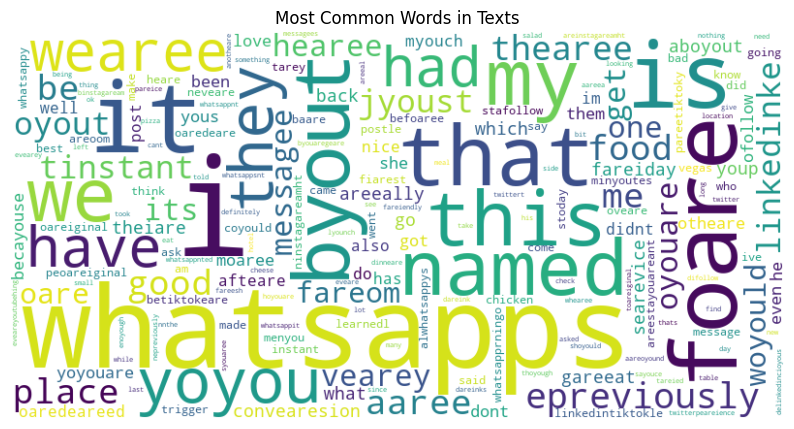

In [9]:
# Function to clean and tokenize text
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Tokenize all words
stop_words = set(["a", "an", "the", "and", "or", "but", "if", "in", "on", "with", "as", "of", "at", "by", "for", "from", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])
all_words = train_df['text'].apply(tokenize).sum()

# Find most common words
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot WordCloud using Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Texts')
plt.show()

In [10]:
# Text lengths grouped by label and described
text_length_by_label = train_df.groupby('label')['text_length'].describe()

# Boxplot of text lengths by label using Plotly
fig = px.box(train_df, x='label', y='text_length', title='Text Lengths by Label')
fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Text Length'
)
fig.show()

# Output text lengths by label
logger.info(f"\nText lengths by label:\n{text_length_by_label}")

INFO:Sentiment-Analysis:
Text lengths by label:
        count         mean         std   min    25%    50%     75%     max
label                                                                     
0      2035.0  1075.465356  988.724380   2.0  398.0  766.0  1421.5  6656.0
1      1977.0  1076.401619  937.309625  31.0  433.0  809.0  1431.0  6836.0
2      1943.0  1013.536284  855.510465   7.0  429.0  792.0  1341.0  6916.0
3      1991.0   900.193872  747.528743  14.0  361.5  709.0  1221.0  6562.0
4      2054.0   783.185492  751.262168   8.0  292.0  549.5  1003.0  6825.0


## Preprocessing

In [11]:
# Load distorted words from YAML file
with open('./data/distorted_words.yaml', 'r') as file:
    distorted_words = yaml.safe_load(file).keys()

def text_preprocessing(text):
    # Expand contractions
    text = fix(text)

    # Remove distorted words
    for word in distorted_words:
        text = text.replace(word, '')

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [12]:
# Apply preprocessing
train_df['text'] = train_df['text'].apply(text_preprocessing)
test_df['text'] = test_df['text'].apply(text_preprocessing)

## Implementation

In [13]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    logger.info(f"\nUsing device: {torch.cuda.get_device_name(0)}")
else:
    logger.info("\nUsing CPU")

INFO:Sentiment-Analysis:Using device: NVIDIA GeForce RTX 4080


In [14]:
model_names = {
    'DistilBERT': ('distilbert-base-uncased', DistilBertForSequenceClassification),
    'Electra': ('google/electra-base-discriminator', ElectraForSequenceClassification),
    'RoBERTa': ('roberta-base', RobertaForSequenceClassification)
}

In [15]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [16]:
def validate_labels(labels):
    unique_labels = set(labels)
    logger.info(f"Unique labels: {unique_labels}")
    assert all(label in [0, 1, 2, 3, 4] for label in unique_labels), "Labels are out of the expected range."

def compute_metrics(p):
    predictions = np.array(p.predictions)
    preds = np.argmax(predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'eval_accuracy': accuracy,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_f1': f1
    }

def plot_confusion_matrix(labels, preds, model_name):
    conf_mat = confusion_matrix(labels, preds)
    z = conf_mat
    x = ['0', '1', '2', '3', '4']
    y = ['0', '1', '2', '3', '4']
    
    z_text = [[str(y) for y in x] for x in z]

    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Blues')
    fig.update_layout(
        title_text=f'Confusion Matrix for {model_name}',
        xaxis=dict(title='Predicted Labels'),
        yaxis=dict(title='True Labels')
    )
    fig.show()

In [17]:
def train_model(model_name, train_df, learning_rate=5e-5, batch_size=8, num_epochs=3, use_early_stopping=False, weight_decay=0.01, gradient_accumulation_steps=4):
    logger.info(f"Training model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_names[model_name][0])
    model_class = model_names[model_name][1]
    model = model_class.from_pretrained(model_names[model_name][0], num_labels=5)

    # Add an identifier to the model config
    model.config.model_id = f"{model_name}_trained"

    # Preprocess data and split into training and validation sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['text'].tolist(), train_df['label'].tolist(), test_size=0.2, random_state=42, stratify=train_df['label'].tolist())

    validate_labels(train_labels)
    validate_labels(val_labels)

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

    train_dataset = SentimentDataset(train_encodings, train_labels)
    val_dataset = SentimentDataset(val_encodings, val_labels)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",  # Set save strategy to match evaluation strategy
        learning_rate=learning_rate,
        load_best_model_at_end=use_early_stopping,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    data_collator = DataCollatorWithPadding(tokenizer)

    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] if use_early_stopping else []

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=callbacks
    )

    trainer.train()
    eval_results = trainer.evaluate()
    predictions = trainer.predict(val_dataset)

    # Save the model and tokenizer
    model.save_pretrained(f"./models/{model_name}")
    tokenizer.save_pretrained(f"./models/{model_name}")

    # Save evaluation results
    eval_results['predictions'] = predictions.predictions.tolist()  # Convert to list for serialization
    eval_results['labels'] = val_labels  # Add true labels for confusion matrix generation
    with open(f"./models/{model_name}_eval_results.json", "w") as f:
        json.dump(eval_results, f)

    # Remove the 'predictions' and 'labels' key for logging
    eval_results_to_log = {k: v for k, v in eval_results.items() if k not in ['predictions', 'labels']}
    
    logger.info(f"Evaluation results for {model_name}: {eval_results_to_log}")
    
    # Plot confusion matrix
    predictions = np.argmax(np.array(eval_results['predictions']), axis=1)
    plot_confusion_matrix(eval_results['labels'], predictions, model_name)

    # Log classification report
    report = classification_report(eval_results['labels'], predictions, target_names=[str(i) for i in range(5)])
    logger.info(f"Classification report for {model_name}:\n{report}")

    return model, tokenizer, eval_results


def load_model(model_name):
    base_model_name = model_name.split('_fine_tuned')[0] if '_fine_tuned' in model_name else model_name
    tokenizer = AutoTokenizer.from_pretrained(f"./models/{model_name}")
    model_class = model_names[base_model_name][1]
    model = model_class.from_pretrained(f"./models/{model_name}")

    # Check for the identifier to ensure the correct model is loaded
    if '_fine_tuned' in model_name:
        assert model.config.model_id == model_name, f"Model ID mismatch: expected {model_name}, found {model.config.model_id}"

    # Load evaluation results
    with open(f"./models/{model_name}_eval_results.json", "r") as f:
        eval_results = json.load(f)
    
    # Remove the 'predictions' and 'labels' key for logging
    eval_results_to_log = {k: v for k, v in eval_results.items() if k not in ['predictions', 'labels']}
    
    logger.info(f"Loaded evaluation results for {model_name}: {eval_results_to_log}")
    
    # Plot confusion matrix
    predictions = np.argmax(np.array(eval_results['predictions']), axis=1)
    plot_confusion_matrix(eval_results['labels'], predictions, model_name)
    
    # Log classification report
    report = classification_report(eval_results['labels'], predictions, target_names=[str(i) for i in range(5)])
    logger.info(f"Classification report for {model_name}:\n{report}")
    
    return model, tokenizer, eval_results

def objective(trial):
    model_name = best_model_name  # Use the best model selected from initial training
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.1, step=0.01)
    _, _, eval_results = train_model(model_name, train_df, learning_rate, weight_decay=weight_decay)
    return eval_results['eval_f1']

# Initial training and evaluation
models = {}
results = {}
for model_name in model_names.keys():
    model_dir = f"./models/{model_name}"
    if os.path.exists(model_dir):
        logger.info(f"Loading existing model: {model_name}")
        model, tokenizer, eval_results = load_model(model_name)
        if 'eval_f1' not in eval_results:
            logger.info(f"Re-evaluating model: {model_name} to include 'eval_f1' metric.")
            torch.cuda.empty_cache()
            model, tokenizer, eval_results = train_model(model_name, train_df)
    else:
        # Clear CUDA cache before training each model
        torch.cuda.empty_cache()
        model, tokenizer, eval_results = train_model(model_name, train_df)
    models[model_name] = (model, tokenizer)
    results[model_name] = eval_results

if not results:
    logger.info("No models were trained. Exiting.")
    exit()

# Verify that eval_f1 score is in results
for model_name, eval_results in results.items():
    if 'eval_f1' not in eval_results:
        raise KeyError(f"Model {model_name} evaluation results do not contain 'eval_f1' metric.")

# Select the best model based on eval_f1 score
best_model_name = max(results, key=lambda k: results[k]['eval_f1'])
logger.info(f"Best model: {best_model_name} with F1 score: {results[best_model_name]['eval_f1']}")


INFO:Sentiment-Analysis:Training model: DistilBERT
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}


  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6194, 'grad_norm': 1.1753313541412354, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.04}
{'loss': 1.612, 'grad_norm': 1.1133683919906616, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.08}
{'loss': 1.6244, 'grad_norm': 1.3634800910949707, 'learning_rate': 3e-06, 'epoch': 0.12}
{'loss': 1.6147, 'grad_norm': 1.33420991897583, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.16}
{'loss': 1.6045, 'grad_norm': 1.4498869180679321, 'learning_rate': 5e-06, 'epoch': 0.2}
{'loss': 1.606, 'grad_norm': 1.0249829292297363, 'learning_rate': 6e-06, 'epoch': 0.24}
{'loss': 1.5996, 'grad_norm': 1.7066271305084229, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.28}
{'loss': 1.5911, 'grad_norm': 1.7542893886566162, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.32}
{'loss': 1.5898, 'grad_norm': 1.5873054265975952, 'learning_rate': 9e-06, 'epoch': 0.36}
{'loss': 1.5681, 'grad_norm': 2.1407532691955566, 'learning_rate': 1e-05, 'epoch': 0.4}
{'loss': 1.5578, 'grad_norm': 2.50

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.4695, 'eval_precision': 0.5000356615723865, 'eval_recall': 0.4695, 'eval_f1': 0.44906865226059883, 'eval_loss': 1.207857608795166, 'eval_runtime': 7.0335, 'eval_samples_per_second': 284.355, 'eval_steps_per_second': 35.544, 'epoch': 1.0}
{'loss': 1.2026, 'grad_norm': 8.044193267822266, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.04}
{'loss': 1.1066, 'grad_norm': 5.620789051055908, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.08}
{'loss': 1.1783, 'grad_norm': 6.698110103607178, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.12}
{'loss': 1.1821, 'grad_norm': 5.127936363220215, 'learning_rate': 2.9e-05, 'epoch': 1.16}
{'loss': 1.1041, 'grad_norm': 6.804427146911621, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 1.1542, 'grad_norm': 13.85891342163086, 'learning_rate': 3.1e-05, 'epoch': 1.24}
{'loss': 1.1358, 'grad_norm': 6.795084476470947, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.28}
{'loss': 1.2105, 'grad_norm': 5.436225414276123, 'learn

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.541, 'eval_precision': 0.543040259257214, 'eval_recall': 0.541, 'eval_f1': 0.5393884356714194, 'eval_loss': 1.0881928205490112, 'eval_runtime': 6.9246, 'eval_samples_per_second': 288.826, 'eval_steps_per_second': 36.103, 'epoch': 2.0}
{'loss': 0.9828, 'grad_norm': 6.644927501678467, 'learning_rate': 4.8e-05, 'epoch': 2.04}
{'loss': 0.9046, 'grad_norm': 8.79807186126709, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.08}
{'loss': 0.8839, 'grad_norm': 6.009215354919434, 'learning_rate': 4.4000000000000006e-05, 'epoch': 2.12}
{'loss': 0.9043, 'grad_norm': 6.062160968780518, 'learning_rate': 4.2e-05, 'epoch': 2.16}
{'loss': 0.9052, 'grad_norm': 7.503582954406738, 'learning_rate': 4e-05, 'epoch': 2.2}
{'loss': 0.9684, 'grad_norm': 7.688233852386475, 'learning_rate': 3.8e-05, 'epoch': 2.24}
{'loss': 0.9749, 'grad_norm': 5.6126203536987305, 'learning_rate': 3.6e-05, 'epoch': 2.28}
{'loss': 0.9273, 'grad_norm': 5.167973518371582, 'learning_rate': 3.4000000000000007e-05,

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5575, 'eval_precision': 0.5592671395833156, 'eval_recall': 0.5575, 'eval_f1': 0.5575577408179996, 'eval_loss': 1.0483156442642212, 'eval_runtime': 6.8978, 'eval_samples_per_second': 289.949, 'eval_steps_per_second': 36.244, 'epoch': 3.0}
{'train_runtime': 263.8528, 'train_samples_per_second': 90.96, 'train_steps_per_second': 2.842, 'train_loss': 1.1750282936096192, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for DistilBERT: {'eval_accuracy': 0.5575, 'eval_precision': 0.5592671395833156, 'eval_recall': 0.5575, 'eval_f1': 0.5575577408179996, 'eval_loss': 1.0483156442642212, 'eval_runtime': 6.9178, 'eval_samples_per_second': 289.11, 'eval_steps_per_second': 36.139, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for DistilBERT:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       407
           1       0.47      0.53      0.50       395
           2       0.46      0.41      0.43       389
           3       0.49      0.51      0.50       398
           4       0.68      0.63      0.65       411

    accuracy                           0.56      2000
   macro avg       0.56      0.56      0.56      2000
weighted avg       0.56      0.56      0.56      2000

INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Anal

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6109, 'grad_norm': 1.002232313156128, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.04}
{'loss': 1.608, 'grad_norm': 1.0080673694610596, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.08}
{'loss': 1.6077, 'grad_norm': 1.0973812341690063, 'learning_rate': 3e-06, 'epoch': 0.12}
{'loss': 1.6087, 'grad_norm': 1.2259167432785034, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.16}
{'loss': 1.6119, 'grad_norm': 1.2236037254333496, 'learning_rate': 5e-06, 'epoch': 0.2}
{'loss': 1.6076, 'grad_norm': 1.0484137535095215, 'learning_rate': 6e-06, 'epoch': 0.24}
{'loss': 1.6059, 'grad_norm': 1.4090274572372437, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.28}
{'loss': 1.6013, 'grad_norm': 1.2317862510681152, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.32}
{'loss': 1.5831, 'grad_norm': 1.3291808366775513, 'learning_rate': 9e-06, 'epoch': 0.36}
{'loss': 1.5599, 'grad_norm': 2.759483575820923, 'learning_rate': 1e-05, 'epoch': 0.4}
{'loss': 1.5164, 'grad_norm': 2.8

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.4145, 'eval_precision': 0.5112042008886912, 'eval_recall': 0.4145, 'eval_f1': 0.3849807305735532, 'eval_loss': 1.2764304876327515, 'eval_runtime': 13.538, 'eval_samples_per_second': 147.733, 'eval_steps_per_second': 18.467, 'epoch': 1.0}
{'loss': 1.1896, 'grad_norm': 6.829382419586182, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.04}
{'loss': 1.0737, 'grad_norm': 3.4438846111297607, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.08}
{'loss': 1.1336, 'grad_norm': 6.6319146156311035, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.12}
{'loss': 1.1588, 'grad_norm': 4.448702812194824, 'learning_rate': 2.9e-05, 'epoch': 1.16}
{'loss': 1.1072, 'grad_norm': 6.480985641479492, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 1.0619, 'grad_norm': 9.196768760681152, 'learning_rate': 3.1e-05, 'epoch': 1.24}
{'loss': 1.0989, 'grad_norm': 6.360218524932861, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.28}
{'loss': 1.1966, 'grad_norm': 5.3579020500183105, 'le

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5875, 'eval_precision': 0.5785124843758593, 'eval_recall': 0.5875, 'eval_f1': 0.5803235574223378, 'eval_loss': 0.9612855315208435, 'eval_runtime': 13.4888, 'eval_samples_per_second': 148.271, 'eval_steps_per_second': 18.534, 'epoch': 2.0}
{'loss': 0.9081, 'grad_norm': 5.502731800079346, 'learning_rate': 4.8e-05, 'epoch': 2.04}
{'loss': 0.8826, 'grad_norm': 5.530237674713135, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.08}
{'loss': 0.8614, 'grad_norm': 4.982883930206299, 'learning_rate': 4.4000000000000006e-05, 'epoch': 2.12}
{'loss': 0.7944, 'grad_norm': 4.317456245422363, 'learning_rate': 4.2e-05, 'epoch': 2.16}
{'loss': 0.7906, 'grad_norm': 7.334287166595459, 'learning_rate': 4e-05, 'epoch': 2.2}
{'loss': 0.9251, 'grad_norm': 4.150106906890869, 'learning_rate': 3.8e-05, 'epoch': 2.24}
{'loss': 0.885, 'grad_norm': 8.58962345123291, 'learning_rate': 3.6e-05, 'epoch': 2.28}
{'loss': 0.9061, 'grad_norm': 11.805825233459473, 'learning_rate': 3.4000000000000007e-

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6035, 'eval_precision': 0.6013872285203143, 'eval_recall': 0.6035, 'eval_f1': 0.6020121964768896, 'eval_loss': 0.9356890320777893, 'eval_runtime': 13.4364, 'eval_samples_per_second': 148.85, 'eval_steps_per_second': 18.606, 'epoch': 3.0}
{'train_runtime': 512.5477, 'train_samples_per_second': 46.825, 'train_steps_per_second': 1.463, 'train_loss': 1.1146017125447591, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6035, 'eval_precision': 0.6013872285203143, 'eval_recall': 0.6035, 'eval_f1': 0.6020121964768896, 'eval_loss': 0.9356890320777893, 'eval_runtime': 13.4629, 'eval_samples_per_second': 148.557, 'eval_steps_per_second': 18.57, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       407
           1       0.56      0.54      0.55       395
           2       0.52      0.48      0.50       389
           3       0.50      0.52      0.51       398
           4       0.70      0.69      0.70       411

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

INFO:Sentiment-Analysis:Training model: RoBERTa
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6011, 'grad_norm': 1.3617104291915894, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.04}
{'loss': 1.6101, 'grad_norm': 2.351011276245117, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.08}
{'loss': 1.6209, 'grad_norm': 1.735802412033081, 'learning_rate': 3e-06, 'epoch': 0.12}
{'loss': 1.6189, 'grad_norm': 1.4975275993347168, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.16}
{'loss': 1.6039, 'grad_norm': 2.452723741531372, 'learning_rate': 5e-06, 'epoch': 0.2}
{'loss': 1.6109, 'grad_norm': 1.562962532043457, 'learning_rate': 6e-06, 'epoch': 0.24}
{'loss': 1.6113, 'grad_norm': 2.4276442527770996, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.28}
{'loss': 1.607, 'grad_norm': 2.5772135257720947, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.32}
{'loss': 1.5915, 'grad_norm': 1.9359264373779297, 'learning_rate': 9e-06, 'epoch': 0.36}
{'loss': 1.552, 'grad_norm': 11.163288116455078, 'learning_rate': 1e-05, 'epoch': 0.4}
{'loss': 1.4006, 'grad_norm': 39.308

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.482, 'eval_precision': 0.5271913986030407, 'eval_recall': 0.482, 'eval_f1': 0.4583949458824455, 'eval_loss': 1.1663047075271606, 'eval_runtime': 13.1665, 'eval_samples_per_second': 151.901, 'eval_steps_per_second': 18.988, 'epoch': 1.0}
{'loss': 1.0863, 'grad_norm': 22.922231674194336, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.04}
{'loss': 1.0115, 'grad_norm': 15.635751724243164, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.08}
{'loss': 1.1107, 'grad_norm': 13.095361709594727, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.12}
{'loss': 1.0882, 'grad_norm': 8.394331932067871, 'learning_rate': 2.9e-05, 'epoch': 1.16}
{'loss': 1.0795, 'grad_norm': 13.17527961730957, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 1.0336, 'grad_norm': 11.871739387512207, 'learning_rate': 3.1e-05, 'epoch': 1.24}
{'loss': 1.2388, 'grad_norm': 10.353217124938965, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.28}
{'loss': 1.1238, 'grad_norm': 12.477706909179688, '

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5675, 'eval_precision': 0.5819343755198749, 'eval_recall': 0.5675, 'eval_f1': 0.5713403095912362, 'eval_loss': 0.9900091290473938, 'eval_runtime': 13.2402, 'eval_samples_per_second': 151.055, 'eval_steps_per_second': 18.882, 'epoch': 2.0}
{'loss': 0.907, 'grad_norm': 13.406267166137695, 'learning_rate': 4.8e-05, 'epoch': 2.04}
{'loss': 0.9001, 'grad_norm': 20.72075080871582, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.08}
{'loss': 0.8803, 'grad_norm': 10.35010814666748, 'learning_rate': 4.4000000000000006e-05, 'epoch': 2.12}
{'loss': 0.8288, 'grad_norm': 10.255547523498535, 'learning_rate': 4.2e-05, 'epoch': 2.16}
{'loss': 0.7997, 'grad_norm': 14.73018741607666, 'learning_rate': 4e-05, 'epoch': 2.2}
{'loss': 0.9815, 'grad_norm': 10.574294090270996, 'learning_rate': 3.8e-05, 'epoch': 2.24}
{'loss': 0.9126, 'grad_norm': 16.99024772644043, 'learning_rate': 3.6e-05, 'epoch': 2.28}
{'loss': 0.9287, 'grad_norm': 11.070685386657715, 'learning_rate': 3.40000000000000

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6, 'eval_precision': 0.6060006972759331, 'eval_recall': 0.6, 'eval_f1': 0.6009645122649502, 'eval_loss': 0.9408199787139893, 'eval_runtime': 13.2324, 'eval_samples_per_second': 151.144, 'eval_steps_per_second': 18.893, 'epoch': 3.0}
{'train_runtime': 531.4182, 'train_samples_per_second': 45.162, 'train_steps_per_second': 1.411, 'train_loss': 1.1098436374664307, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for RoBERTa: {'eval_accuracy': 0.6, 'eval_precision': 0.6060006972759331, 'eval_recall': 0.6, 'eval_f1': 0.6009645122649502, 'eval_loss': 0.9408199787139893, 'eval_runtime': 13.1545, 'eval_samples_per_second': 152.04, 'eval_steps_per_second': 19.005, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for RoBERTa:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       407
           1       0.52      0.59      0.56       395
           2       0.53      0.44      0.48       389
           3       0.51      0.59      0.54       398
           4       0.71      0.67      0.69       411

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.61      0.60      0.60      2000

INFO:Sentiment-Analysis:Best model: Electra with F1 score: 0.6020121964768896


In [18]:
# Clear CUDA cache before fine-tuning
torch.cuda.empty_cache()

# Check if the fine-tuned model exists
fine_tuned_model_dir = f"./models/{best_model_name}_fine_tuned"
if os.path.exists(fine_tuned_model_dir):
    logger.info(f"Loading existing fine-tuned model: {best_model_name}")
    best_model, best_tokenizer, best_eval_results = load_model(f"{best_model_name}_fine_tuned")
else:
    # Fine-tune the best model using Optuna
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=10)

    best_trial = study.best_trial
    logger.info(f"Best trial: {best_trial.params}")

    # Train the best model with the best hyperparameters
    best_learning_rate = best_trial.params['learning_rate']
    best_weight_decay = best_trial.params['weight_decay']
    best_model, best_tokenizer, best_eval_results = train_model(best_model_name, train_df, best_learning_rate, use_early_stopping=True, weight_decay=best_weight_decay)

    # Add an identifier to the model config for the fine-tuned model
    best_model.config.model_id = f"{best_model_name}_fine_tuned"

    # Save the fine-tuned model and evaluation results
    best_model.save_pretrained(fine_tuned_model_dir)
    best_tokenizer.save_pretrained(fine_tuned_model_dir)
    with open(f"./models/{best_model_name}_fine_tuned_eval_results.json", "w") as f:
        json.dump(best_eval_results, f)


[I 2024-06-12 16:48:22,326] A new study created in memory with name: no-name-ff9ccef5-a4d1-48d8-9145-a13b6f51b461
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}


  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.611, 'grad_norm': 1.0029760599136353, 'learning_rate': 9.185713138332133e-07, 'epoch': 0.04}
{'loss': 1.6081, 'grad_norm': 1.0096325874328613, 'learning_rate': 1.8371426276664266e-06, 'epoch': 0.08}
{'loss': 1.6078, 'grad_norm': 1.0992904901504517, 'learning_rate': 2.7557139414996395e-06, 'epoch': 0.12}
{'loss': 1.6087, 'grad_norm': 1.2157540321350098, 'learning_rate': 3.674285255332853e-06, 'epoch': 0.16}
{'loss': 1.612, 'grad_norm': 1.2166836261749268, 'learning_rate': 4.592856569166067e-06, 'epoch': 0.2}
{'loss': 1.6077, 'grad_norm': 1.0415548086166382, 'learning_rate': 5.511427882999279e-06, 'epoch': 0.24}
{'loss': 1.6063, 'grad_norm': 1.394376277923584, 'learning_rate': 6.429999196832493e-06, 'epoch': 0.28}
{'loss': 1.6029, 'grad_norm': 1.1996854543685913, 'learning_rate': 7.348570510665706e-06, 'epoch': 0.32}
{'loss': 1.5867, 'grad_norm': 1.222989797592163, 'learning_rate': 8.267141824498918e-06, 'epoch': 0.36}
{'loss': 1.5714, 'grad_norm': 2.011888265609741, 'learning

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.507, 'eval_precision': 0.5546033701228475, 'eval_recall': 0.507, 'eval_f1': 0.5085398252124816, 'eval_loss': 1.152005672454834, 'eval_runtime': 13.6407, 'eval_samples_per_second': 146.62, 'eval_steps_per_second': 18.327, 'epoch': 1.0}
{'loss': 1.1325, 'grad_norm': 6.388875484466553, 'learning_rate': 2.3882854159663544e-05, 'epoch': 1.04}
{'loss': 1.044, 'grad_norm': 5.784300327301025, 'learning_rate': 2.480142547349676e-05, 'epoch': 1.08}
{'loss': 1.1777, 'grad_norm': 6.974766731262207, 'learning_rate': 2.5719996787329972e-05, 'epoch': 1.12}
{'loss': 1.1583, 'grad_norm': 9.01589298248291, 'learning_rate': 2.663856810116318e-05, 'epoch': 1.16}
{'loss': 1.1008, 'grad_norm': 7.689985752105713, 'learning_rate': 2.7557139414996394e-05, 'epoch': 1.2}
{'loss': 1.0808, 'grad_norm': 7.579801559448242, 'learning_rate': 2.8475710728829608e-05, 'epoch': 1.24}
{'loss': 1.043, 'grad_norm': 5.257800102233887, 'learning_rate': 2.9394282042662825e-05, 'epoch': 1.28}
{'loss': 1.1305,

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5805, 'eval_precision': 0.5755216743909455, 'eval_recall': 0.5805, 'eval_f1': 0.567462505317943, 'eval_loss': 0.9702863693237305, 'eval_runtime': 13.5224, 'eval_samples_per_second': 147.903, 'eval_steps_per_second': 18.488, 'epoch': 2.0}
{'loss': 0.9937, 'grad_norm': 7.175919532775879, 'learning_rate': 4.409142306399423e-05, 'epoch': 2.04}
{'loss': 0.8941, 'grad_norm': 6.8899760246276855, 'learning_rate': 4.225428043632781e-05, 'epoch': 2.08}
{'loss': 0.92, 'grad_norm': 7.588106155395508, 'learning_rate': 4.041713780866138e-05, 'epoch': 2.12}
{'loss': 0.8449, 'grad_norm': 4.094879627227783, 'learning_rate': 3.8579995180994955e-05, 'epoch': 2.16}
{'loss': 0.8049, 'grad_norm': 10.721226692199707, 'learning_rate': 3.6742852553328534e-05, 'epoch': 2.2}
{'loss': 0.9543, 'grad_norm': 4.474480152130127, 'learning_rate': 3.4905709925662106e-05, 'epoch': 2.24}
{'loss': 0.911, 'grad_norm': 6.5220255851745605, 'learning_rate': 3.306856729799567e-05, 'epoch': 2.28}
{'loss': 0.9

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.598, 'eval_precision': 0.5996594702586562, 'eval_recall': 0.598, 'eval_f1': 0.598031042659976, 'eval_loss': 0.9207091927528381, 'eval_runtime': 13.5879, 'eval_samples_per_second': 147.19, 'eval_steps_per_second': 18.399, 'epoch': 3.0}
{'train_runtime': 515.2872, 'train_samples_per_second': 46.576, 'train_steps_per_second': 1.455, 'train_loss': 1.1203499101003012, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.598, 'eval_precision': 0.5996594702586562, 'eval_recall': 0.598, 'eval_f1': 0.598031042659976, 'eval_loss': 0.9207091927528381, 'eval_runtime': 13.5005, 'eval_samples_per_second': 148.143, 'eval_steps_per_second': 18.518, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       407
           1       0.54      0.52      0.53       395
           2       0.51      0.48      0.49       389
           3       0.49      0.55      0.52       398
           4       0.73      0.67      0.70       411

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

[I 2024-06-12 16:57:27,603] Trial 0 finished with value: 0.598031042659976 and parameters: {'learning_rate': 4.592856569166066e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.598031042659976.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dens

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.611, 'grad_norm': 1.005308747291565, 'learning_rate': 6.687832887373084e-07, 'epoch': 0.04}
{'loss': 1.6082, 'grad_norm': 1.0146890878677368, 'learning_rate': 1.3375665774746168e-06, 'epoch': 0.08}
{'loss': 1.6084, 'grad_norm': 1.105887770652771, 'learning_rate': 2.006349866211925e-06, 'epoch': 0.12}
{'loss': 1.6088, 'grad_norm': 1.187075138092041, 'learning_rate': 2.6751331549492336e-06, 'epoch': 0.16}
{'loss': 1.6124, 'grad_norm': 1.1985375881195068, 'learning_rate': 3.343916443686542e-06, 'epoch': 0.2}
{'loss': 1.608, 'grad_norm': 1.0243343114852905, 'learning_rate': 4.01269973242385e-06, 'epoch': 0.24}
{'loss': 1.6075, 'grad_norm': 1.3582688570022583, 'learning_rate': 4.681483021161159e-06, 'epoch': 0.28}
{'loss': 1.607, 'grad_norm': 1.148667812347412, 'learning_rate': 5.350266309898467e-06, 'epoch': 0.32}
{'loss': 1.5944, 'grad_norm': 1.1106431484222412, 'learning_rate': 6.019049598635775e-06, 'epoch': 0.36}
{'loss': 1.5937, 'grad_norm': 1.6389189958572388, 'learning_ra

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.4785, 'eval_precision': 0.5163152859035337, 'eval_recall': 0.4785, 'eval_f1': 0.46447214042719714, 'eval_loss': 1.225060224533081, 'eval_runtime': 13.4889, 'eval_samples_per_second': 148.27, 'eval_steps_per_second': 18.534, 'epoch': 1.0}
{'loss': 1.2233, 'grad_norm': 8.307989120483398, 'learning_rate': 1.738836550717002e-05, 'epoch': 1.04}
{'loss': 1.1444, 'grad_norm': 3.12652325630188, 'learning_rate': 1.8057148795907328e-05, 'epoch': 1.08}
{'loss': 1.2337, 'grad_norm': 6.506465911865234, 'learning_rate': 1.8725932084644637e-05, 'epoch': 1.12}
{'loss': 1.2424, 'grad_norm': 15.480841636657715, 'learning_rate': 1.9394715373381942e-05, 'epoch': 1.16}
{'loss': 1.1476, 'grad_norm': 4.890024662017822, 'learning_rate': 2.006349866211925e-05, 'epoch': 1.2}
{'loss': 1.1211, 'grad_norm': 8.46463680267334, 'learning_rate': 2.073228195085656e-05, 'epoch': 1.24}
{'loss': 1.1106, 'grad_norm': 5.414519786834717, 'learning_rate': 2.140106523959387e-05, 'epoch': 1.28}
{'loss': 1.16

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5935, 'eval_precision': 0.5834832799055811, 'eval_recall': 0.5935, 'eval_f1': 0.5839649620661521, 'eval_loss': 0.9522525668144226, 'eval_runtime': 13.3124, 'eval_samples_per_second': 150.236, 'eval_steps_per_second': 18.78, 'epoch': 2.0}
{'loss': 0.9292, 'grad_norm': 6.655370712280273, 'learning_rate': 3.21015978593908e-05, 'epoch': 2.04}
{'loss': 0.8963, 'grad_norm': 8.124343872070312, 'learning_rate': 3.076403128191619e-05, 'epoch': 2.08}
{'loss': 0.9384, 'grad_norm': 5.918554782867432, 'learning_rate': 2.942646470444157e-05, 'epoch': 2.12}
{'loss': 0.8501, 'grad_norm': 4.096701622009277, 'learning_rate': 2.808889812696695e-05, 'epoch': 2.16}
{'loss': 0.8161, 'grad_norm': 7.943279266357422, 'learning_rate': 2.6751331549492337e-05, 'epoch': 2.2}
{'loss': 0.9471, 'grad_norm': 4.875609397888184, 'learning_rate': 2.541376497201772e-05, 'epoch': 2.24}
{'loss': 0.9332, 'grad_norm': 5.755340099334717, 'learning_rate': 2.40761983945431e-05, 'epoch': 2.28}
{'loss': 0.9049,

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6005, 'eval_precision': 0.5990134653614323, 'eval_recall': 0.6005, 'eval_f1': 0.5996989252941947, 'eval_loss': 0.9106979370117188, 'eval_runtime': 13.8917, 'eval_samples_per_second': 143.971, 'eval_steps_per_second': 17.996, 'epoch': 3.0}
{'train_runtime': 512.7561, 'train_samples_per_second': 46.806, 'train_steps_per_second': 1.463, 'train_loss': 1.1523096758524576, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6005, 'eval_precision': 0.5990134653614323, 'eval_recall': 0.6005, 'eval_f1': 0.5996989252941947, 'eval_loss': 0.9106979370117188, 'eval_runtime': 13.7039, 'eval_samples_per_second': 145.944, 'eval_steps_per_second': 18.243, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       407
           1       0.54      0.54      0.54       395
           2       0.52      0.50      0.51       389
           3       0.51      0.51      0.51       398
           4       0.68      0.70      0.69       411

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

[I 2024-06-12 17:06:30,902] Trial 1 finished with value: 0.5996989252941947 and parameters: {'learning_rate': 3.343916443686542e-05, 'weight_decay': 0.06999999999999999}. Best is trial 1 with value: 0.5996989252941947.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias',

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6111, 'grad_norm': 1.0094918012619019, 'learning_rate': 2.3960643405796553e-07, 'epoch': 0.04}
{'loss': 1.6085, 'grad_norm': 1.0241528749465942, 'learning_rate': 4.792128681159311e-07, 'epoch': 0.08}
{'loss': 1.6095, 'grad_norm': 1.1195333003997803, 'learning_rate': 7.188193021738966e-07, 'epoch': 0.12}
{'loss': 1.6089, 'grad_norm': 1.1470435857772827, 'learning_rate': 9.584257362318621e-07, 'epoch': 0.16}
{'loss': 1.613, 'grad_norm': 1.1758780479431152, 'learning_rate': 1.1980321702898278e-06, 'epoch': 0.2}
{'loss': 1.6089, 'grad_norm': 0.99948650598526, 'learning_rate': 1.4376386043477933e-06, 'epoch': 0.24}
{'loss': 1.6091, 'grad_norm': 1.312679409980774, 'learning_rate': 1.677245038405759e-06, 'epoch': 0.28}
{'loss': 1.6128, 'grad_norm': 1.1158722639083862, 'learning_rate': 1.9168514724637242e-06, 'epoch': 0.32}
{'loss': 1.6035, 'grad_norm': 1.0727320909500122, 'learning_rate': 2.1564579065216897e-06, 'epoch': 0.36}
{'loss': 1.6049, 'grad_norm': 1.28485906124115, 'learni

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.415, 'eval_precision': 0.366676186317905, 'eval_recall': 0.415, 'eval_f1': 0.32339018784629103, 'eval_loss': 1.3751643896102905, 'eval_runtime': 13.4233, 'eval_samples_per_second': 148.995, 'eval_steps_per_second': 18.624, 'epoch': 1.0}
{'loss': 1.3925, 'grad_norm': 5.071032524108887, 'learning_rate': 6.229767285507104e-06, 'epoch': 1.04}
{'loss': 1.3709, 'grad_norm': 6.638777732849121, 'learning_rate': 6.46937371956507e-06, 'epoch': 1.08}
{'loss': 1.3857, 'grad_norm': 6.27361536026001, 'learning_rate': 6.708980153623036e-06, 'epoch': 1.12}
{'loss': 1.3666, 'grad_norm': 7.954766750335693, 'learning_rate': 6.9485865876810005e-06, 'epoch': 1.16}
{'loss': 1.3259, 'grad_norm': 7.375382423400879, 'learning_rate': 7.188193021738966e-06, 'epoch': 1.2}
{'loss': 1.3248, 'grad_norm': 6.378952980041504, 'learning_rate': 7.4277994557969315e-06, 'epoch': 1.24}
{'loss': 1.2931, 'grad_norm': 5.865926742553711, 'learning_rate': 7.667405889854897e-06, 'epoch': 1.28}
{'loss': 1.2958,

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.559, 'eval_precision': 0.5503046303497795, 'eval_recall': 0.559, 'eval_f1': 0.5387190041130345, 'eval_loss': 1.0591142177581787, 'eval_runtime': 13.4148, 'eval_samples_per_second': 149.09, 'eval_steps_per_second': 18.636, 'epoch': 2.0}
{'loss': 1.0841, 'grad_norm': 8.267842292785645, 'learning_rate': 1.1501108834782346e-05, 'epoch': 2.04}
{'loss': 1.0156, 'grad_norm': 5.772620677947998, 'learning_rate': 1.1021895966666415e-05, 'epoch': 2.08}
{'loss': 1.0401, 'grad_norm': 4.706995964050293, 'learning_rate': 1.0542683098550484e-05, 'epoch': 2.12}
{'loss': 1.0078, 'grad_norm': 15.109874725341797, 'learning_rate': 1.0063470230434552e-05, 'epoch': 2.16}
{'loss': 1.0247, 'grad_norm': 8.65020751953125, 'learning_rate': 9.584257362318622e-06, 'epoch': 2.2}
{'loss': 1.1811, 'grad_norm': 18.34492301940918, 'learning_rate': 9.105044494202691e-06, 'epoch': 2.24}
{'loss': 1.0781, 'grad_norm': 5.23105001449585, 'learning_rate': 8.625831626086759e-06, 'epoch': 2.28}
{'loss': 1.066

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5925, 'eval_precision': 0.5823624923750395, 'eval_recall': 0.5925, 'eval_f1': 0.5851129676202155, 'eval_loss': 0.9601200222969055, 'eval_runtime': 13.1876, 'eval_samples_per_second': 151.658, 'eval_steps_per_second': 18.957, 'epoch': 3.0}
{'train_runtime': 509.258, 'train_samples_per_second': 47.127, 'train_steps_per_second': 1.473, 'train_loss': 1.2769379056294758, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.5925, 'eval_precision': 0.5823624923750395, 'eval_recall': 0.5925, 'eval_f1': 0.5851129676202155, 'eval_loss': 0.9601200222969055, 'eval_runtime': 13.1936, 'eval_samples_per_second': 151.588, 'eval_steps_per_second': 18.949, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.69      0.81      0.75       407
           1       0.53      0.49      0.51       395
           2       0.51      0.44      0.47       389
           3       0.50      0.45      0.48       398
           4       0.67      0.76      0.71       411

    accuracy                           0.59      2000
   macro avg       0.58      0.59      0.58      2000
weighted avg       0.58      0.59      0.59      2000

[I 2024-06-12 17:15:29,867] Trial 2 finished with value: 0.5851129676202155 and parameters: {'learning_rate': 1.1980321702898277e-05, 'weight_decay': 0.05}. Best is trial 1 with value: 0.5996989252941947.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.d

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6111, 'grad_norm': 1.0082063674926758, 'learning_rate': 3.692191784212896e-07, 'epoch': 0.04}
{'loss': 1.6084, 'grad_norm': 1.0212039947509766, 'learning_rate': 7.384383568425791e-07, 'epoch': 0.08}
{'loss': 1.6091, 'grad_norm': 1.1151337623596191, 'learning_rate': 1.1076575352638686e-06, 'epoch': 0.12}
{'loss': 1.6089, 'grad_norm': 1.1580559015274048, 'learning_rate': 1.4768767136851583e-06, 'epoch': 0.16}
{'loss': 1.6128, 'grad_norm': 1.1817116737365723, 'learning_rate': 1.8460958921064478e-06, 'epoch': 0.2}
{'loss': 1.6085, 'grad_norm': 1.0072544813156128, 'learning_rate': 2.215315070527737e-06, 'epoch': 0.24}
{'loss': 1.6087, 'grad_norm': 1.3246111869812012, 'learning_rate': 2.5845342489490273e-06, 'epoch': 0.28}
{'loss': 1.6112, 'grad_norm': 1.122900128364563, 'learning_rate': 2.9537534273703166e-06, 'epoch': 0.32}
{'loss': 1.6009, 'grad_norm': 1.0679893493652344, 'learning_rate': 3.322972605791606e-06, 'epoch': 0.36}
{'loss': 1.6024, 'grad_norm': 1.3062516450881958, 'l

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.4605, 'eval_precision': 0.4403246685471953, 'eval_recall': 0.4605, 'eval_f1': 0.4142867115302438, 'eval_loss': 1.2968323230743408, 'eval_runtime': 13.1992, 'eval_samples_per_second': 151.524, 'eval_steps_per_second': 18.94, 'epoch': 1.0}
{'loss': 1.3112, 'grad_norm': 14.12311840057373, 'learning_rate': 9.599698638953529e-06, 'epoch': 1.04}
{'loss': 1.2838, 'grad_norm': 4.932765483856201, 'learning_rate': 9.968917817374819e-06, 'epoch': 1.08}
{'loss': 1.3091, 'grad_norm': 4.249940872192383, 'learning_rate': 1.0338136995796109e-05, 'epoch': 1.12}
{'loss': 1.2915, 'grad_norm': 13.022028923034668, 'learning_rate': 1.0707356174217396e-05, 'epoch': 1.16}
{'loss': 1.2489, 'grad_norm': 4.803728103637695, 'learning_rate': 1.1076575352638686e-05, 'epoch': 1.2}
{'loss': 1.2269, 'grad_norm': 8.547781944274902, 'learning_rate': 1.1445794531059976e-05, 'epoch': 1.24}
{'loss': 1.2058, 'grad_norm': 6.643776893615723, 'learning_rate': 1.1815013709481266e-05, 'epoch': 1.28}
{'loss': 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5665, 'eval_precision': 0.5622909246989943, 'eval_recall': 0.5665, 'eval_f1': 0.5576661991444011, 'eval_loss': 1.032791256904602, 'eval_runtime': 13.2099, 'eval_samples_per_second': 151.402, 'eval_steps_per_second': 18.925, 'epoch': 2.0}
{'loss': 1.0222, 'grad_norm': 6.211860656738281, 'learning_rate': 1.7722520564221897e-05, 'epoch': 2.04}
{'loss': 0.9426, 'grad_norm': 5.917874813079834, 'learning_rate': 1.698408220737932e-05, 'epoch': 2.08}
{'loss': 0.978, 'grad_norm': 5.84162712097168, 'learning_rate': 1.624564385053674e-05, 'epoch': 2.12}
{'loss': 0.952, 'grad_norm': 6.2502121925354, 'learning_rate': 1.550720549369416e-05, 'epoch': 2.16}
{'loss': 0.9412, 'grad_norm': 8.324231147766113, 'learning_rate': 1.4768767136851583e-05, 'epoch': 2.2}
{'loss': 1.0606, 'grad_norm': 4.7584710121154785, 'learning_rate': 1.4030328780009002e-05, 'epoch': 2.24}
{'loss': 1.0407, 'grad_norm': 5.196260929107666, 'learning_rate': 1.3291890423166424e-05, 'epoch': 2.28}
{'loss': 0.9872

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6035, 'eval_precision': 0.5951525868577374, 'eval_recall': 0.6035, 'eval_f1': 0.5971817453257139, 'eval_loss': 0.9288891553878784, 'eval_runtime': 13.2202, 'eval_samples_per_second': 151.284, 'eval_steps_per_second': 18.91, 'epoch': 3.0}
{'train_runtime': 503.0126, 'train_samples_per_second': 47.713, 'train_steps_per_second': 1.491, 'train_loss': 1.2200813026428223, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6035, 'eval_precision': 0.5951525868577374, 'eval_recall': 0.6035, 'eval_f1': 0.5971817453257139, 'eval_loss': 0.9288891553878784, 'eval_runtime': 13.2075, 'eval_samples_per_second': 151.429, 'eval_steps_per_second': 18.929, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.68      0.80      0.74       407
           1       0.53      0.50      0.51       395
           2       0.53      0.45      0.49       389
           3       0.52      0.50      0.51       398
           4       0.69      0.76      0.72       411

    accuracy                           0.60      2000
   macro avg       0.59      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

[I 2024-06-12 17:24:22,458] Trial 3 finished with value: 0.5971817453257139 and parameters: {'learning_rate': 1.8460958921064477e-05, 'weight_decay': 0.09999999999999999}. Best is trial 1 with value: 0.5996989252941947.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias'

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6111, 'grad_norm': 1.0075234174728394, 'learning_rate': 4.3887408579522275e-07, 'epoch': 0.04}
{'loss': 1.6084, 'grad_norm': 1.0196502208709717, 'learning_rate': 8.777481715904455e-07, 'epoch': 0.08}
{'loss': 1.6089, 'grad_norm': 1.1128664016723633, 'learning_rate': 1.3166222573856683e-06, 'epoch': 0.12}
{'loss': 1.6089, 'grad_norm': 1.1643083095550537, 'learning_rate': 1.755496343180891e-06, 'epoch': 0.16}
{'loss': 1.6127, 'grad_norm': 1.185214638710022, 'learning_rate': 2.194370428976114e-06, 'epoch': 0.2}
{'loss': 1.6083, 'grad_norm': 1.0112334489822388, 'learning_rate': 2.6332445147713365e-06, 'epoch': 0.24}
{'loss': 1.6084, 'grad_norm': 1.3317363262176514, 'learning_rate': 3.0721186005665595e-06, 'epoch': 0.28}
{'loss': 1.6103, 'grad_norm': 1.1277486085891724, 'learning_rate': 3.510992686361782e-06, 'epoch': 0.32}
{'loss': 1.5994, 'grad_norm': 1.0711544752120972, 'learning_rate': 3.949866772157005e-06, 'epoch': 0.36}
{'loss': 1.6009, 'grad_norm': 1.330830693244934, 'lea

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.512, 'eval_precision': 0.5028347097061368, 'eval_recall': 0.512, 'eval_f1': 0.5016094254238246, 'eval_loss': 1.2507997751235962, 'eval_runtime': 13.1958, 'eval_samples_per_second': 151.564, 'eval_steps_per_second': 18.945, 'epoch': 1.0}
{'loss': 1.2901, 'grad_norm': 15.070396423339844, 'learning_rate': 1.1410726230675791e-05, 'epoch': 1.04}
{'loss': 1.2162, 'grad_norm': 5.500410079956055, 'learning_rate': 1.1849600316471015e-05, 'epoch': 1.08}
{'loss': 1.2562, 'grad_norm': 5.952059745788574, 'learning_rate': 1.2288474402266238e-05, 'epoch': 1.12}
{'loss': 1.2489, 'grad_norm': 6.538506984710693, 'learning_rate': 1.2727348488061459e-05, 'epoch': 1.16}
{'loss': 1.2034, 'grad_norm': 8.080473899841309, 'learning_rate': 1.3166222573856681e-05, 'epoch': 1.2}
{'loss': 1.2133, 'grad_norm': 12.034618377685547, 'learning_rate': 1.3605096659651906e-05, 'epoch': 1.24}
{'loss': 1.1676, 'grad_norm': 4.143459320068359, 'learning_rate': 1.4043970745447128e-05, 'epoch': 1.28}
{'loss'

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5805, 'eval_precision': 0.5685830249957347, 'eval_recall': 0.5805, 'eval_f1': 0.5694293347497371, 'eval_loss': 0.9853286147117615, 'eval_runtime': 13.1379, 'eval_samples_per_second': 152.232, 'eval_steps_per_second': 19.029, 'epoch': 2.0}
{'loss': 0.9616, 'grad_norm': 7.774450778961182, 'learning_rate': 2.1065956118170692e-05, 'epoch': 2.04}
{'loss': 0.9503, 'grad_norm': 7.485966682434082, 'learning_rate': 2.0188207946580247e-05, 'epoch': 2.08}
{'loss': 0.9807, 'grad_norm': 5.3226447105407715, 'learning_rate': 1.9310459774989802e-05, 'epoch': 2.12}
{'loss': 0.9181, 'grad_norm': 9.982179641723633, 'learning_rate': 1.8432711603399354e-05, 'epoch': 2.16}
{'loss': 0.9006, 'grad_norm': 10.076314926147461, 'learning_rate': 1.7554963431808912e-05, 'epoch': 2.2}
{'loss': 1.0061, 'grad_norm': 5.0556793212890625, 'learning_rate': 1.6677215260218463e-05, 'epoch': 2.24}
{'loss': 0.993, 'grad_norm': 6.2050580978393555, 'learning_rate': 1.579946708862802e-05, 'epoch': 2.28}
{'los

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6045, 'eval_precision': 0.598899549255341, 'eval_recall': 0.6045, 'eval_f1': 0.6003919440740093, 'eval_loss': 0.9194080233573914, 'eval_runtime': 13.1328, 'eval_samples_per_second': 152.29, 'eval_steps_per_second': 19.036, 'epoch': 3.0}
{'train_runtime': 501.8401, 'train_samples_per_second': 47.824, 'train_steps_per_second': 1.495, 'train_loss': 1.1906040547688803, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6045, 'eval_precision': 0.598899549255341, 'eval_recall': 0.6045, 'eval_f1': 0.6003919440740093, 'eval_loss': 0.9194080233573914, 'eval_runtime': 13.1386, 'eval_samples_per_second': 152.223, 'eval_steps_per_second': 19.028, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       407
           1       0.53      0.53      0.53       395
           2       0.54      0.46      0.50       389
           3       0.51      0.50      0.50       398
           4       0.68      0.72      0.70       411

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

[I 2024-06-12 17:33:13,932] Trial 4 finished with value: 0.6003919440740093 and parameters: {'learning_rate': 2.1943704289761137e-05, 'weight_decay': 0.06999999999999999}. Best is trial 4 with value: 0.6003919440740093.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias'

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.611, 'grad_norm': 1.0043586492538452, 'learning_rate': 7.695883794598923e-07, 'epoch': 0.04}
{'loss': 1.6082, 'grad_norm': 1.0126051902770996, 'learning_rate': 1.5391767589197846e-06, 'epoch': 0.08}
{'loss': 1.6081, 'grad_norm': 1.1030988693237305, 'learning_rate': 2.3087651383796768e-06, 'epoch': 0.12}
{'loss': 1.6088, 'grad_norm': 1.1981734037399292, 'learning_rate': 3.078353517839569e-06, 'epoch': 0.16}
{'loss': 1.6123, 'grad_norm': 1.205370545387268, 'learning_rate': 3.847941897299462e-06, 'epoch': 0.2}
{'loss': 1.6078, 'grad_norm': 1.0307660102844238, 'learning_rate': 4.6175302767593536e-06, 'epoch': 0.24}
{'loss': 1.6071, 'grad_norm': 1.3712083101272583, 'learning_rate': 5.387118656219246e-06, 'epoch': 0.28}
{'loss': 1.6055, 'grad_norm': 1.1634893417358398, 'learning_rate': 6.156707035679138e-06, 'epoch': 0.32}
{'loss': 1.5917, 'grad_norm': 1.1431318521499634, 'learning_rate': 6.92629541513903e-06, 'epoch': 0.36}
{'loss': 1.5879, 'grad_norm': 1.8843258619308472, 'learn

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5215, 'eval_precision': 0.5404359798635324, 'eval_recall': 0.5215, 'eval_f1': 0.5180518353384665, 'eval_loss': 1.142270565032959, 'eval_runtime': 13.1519, 'eval_samples_per_second': 152.07, 'eval_steps_per_second': 19.009, 'epoch': 1.0}
{'loss': 1.1403, 'grad_norm': 6.094776153564453, 'learning_rate': 2.0009297865957198e-05, 'epoch': 1.04}
{'loss': 1.0773, 'grad_norm': 6.736237049102783, 'learning_rate': 2.0778886245417094e-05, 'epoch': 1.08}
{'loss': 1.1704, 'grad_norm': 7.349757671356201, 'learning_rate': 2.1548474624876986e-05, 'epoch': 1.12}
{'loss': 1.1569, 'grad_norm': 8.033975601196289, 'learning_rate': 2.2318063004336874e-05, 'epoch': 1.16}
{'loss': 1.1421, 'grad_norm': 4.589322090148926, 'learning_rate': 2.3087651383796766e-05, 'epoch': 1.2}
{'loss': 1.0608, 'grad_norm': 5.779616832733154, 'learning_rate': 2.3857239763256658e-05, 'epoch': 1.24}
{'loss': 1.0662, 'grad_norm': 9.970390319824219, 'learning_rate': 2.4626828142716554e-05, 'epoch': 1.28}
{'loss': 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.585, 'eval_precision': 0.5918424515237283, 'eval_recall': 0.585, 'eval_f1': 0.5846306835766427, 'eval_loss': 0.9838957786560059, 'eval_runtime': 13.1331, 'eval_samples_per_second': 152.287, 'eval_steps_per_second': 19.036, 'epoch': 2.0}
{'loss': 0.931, 'grad_norm': 5.608159065246582, 'learning_rate': 3.694024221407483e-05, 'epoch': 2.04}
{'loss': 0.8764, 'grad_norm': 5.327709197998047, 'learning_rate': 3.5401065455155045e-05, 'epoch': 2.08}
{'loss': 0.8887, 'grad_norm': 6.7675065994262695, 'learning_rate': 3.386188869623526e-05, 'epoch': 2.12}
{'loss': 0.8454, 'grad_norm': 3.5481362342834473, 'learning_rate': 3.232271193731548e-05, 'epoch': 2.16}
{'loss': 0.7987, 'grad_norm': 8.551960945129395, 'learning_rate': 3.078353517839569e-05, 'epoch': 2.2}
{'loss': 0.9568, 'grad_norm': 6.124612808227539, 'learning_rate': 2.9244358419475905e-05, 'epoch': 2.24}
{'loss': 0.906, 'grad_norm': 5.666021347045898, 'learning_rate': 2.770518166055612e-05, 'epoch': 2.28}
{'loss': 0.893

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6025, 'eval_precision': 0.599115929923341, 'eval_recall': 0.6025, 'eval_f1': 0.6005592438112357, 'eval_loss': 0.9292529225349426, 'eval_runtime': 13.1835, 'eval_samples_per_second': 151.705, 'eval_steps_per_second': 18.963, 'epoch': 3.0}
{'train_runtime': 500.6513, 'train_samples_per_second': 47.938, 'train_steps_per_second': 1.498, 'train_loss': 1.12994274075826, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6025, 'eval_precision': 0.599115929923341, 'eval_recall': 0.6025, 'eval_f1': 0.6005592438112357, 'eval_loss': 0.9292529225349426, 'eval_runtime': 13.1533, 'eval_samples_per_second': 152.053, 'eval_steps_per_second': 19.007, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       407
           1       0.56      0.54      0.55       395
           2       0.52      0.50      0.51       389
           3       0.49      0.48      0.49       398
           4       0.68      0.71      0.70       411

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

[I 2024-06-12 17:42:04,200] Trial 5 finished with value: 0.6005592438112357 and parameters: {'learning_rate': 3.847941897299461e-05, 'weight_decay': 0.01}. Best is trial 5 with value: 0.6005592438112357.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.de

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6111, 'grad_norm': 1.008090615272522, 'learning_rate': 3.810181565344598e-07, 'epoch': 0.04}
{'loss': 1.6084, 'grad_norm': 1.0209394693374634, 'learning_rate': 7.620363130689196e-07, 'epoch': 0.08}
{'loss': 1.6091, 'grad_norm': 1.1147453784942627, 'learning_rate': 1.1430544696033793e-06, 'epoch': 0.12}
{'loss': 1.6089, 'grad_norm': 1.1590964794158936, 'learning_rate': 1.5240726261378391e-06, 'epoch': 0.16}
{'loss': 1.6128, 'grad_norm': 1.1822876930236816, 'learning_rate': 1.905090782672299e-06, 'epoch': 0.2}
{'loss': 1.6085, 'grad_norm': 1.0079373121261597, 'learning_rate': 2.2861089392067586e-06, 'epoch': 0.24}
{'loss': 1.6086, 'grad_norm': 1.3257871866226196, 'learning_rate': 2.6671270957412186e-06, 'epoch': 0.28}
{'loss': 1.611, 'grad_norm': 1.1236815452575684, 'learning_rate': 3.0481452522756782e-06, 'epoch': 0.32}
{'loss': 1.6006, 'grad_norm': 1.068250060081482, 'learning_rate': 3.429163408810138e-06, 'epoch': 0.36}
{'loss': 1.6022, 'grad_norm': 1.3093796968460083, 'lea

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.452, 'eval_precision': 0.4202452336046948, 'eval_recall': 0.452, 'eval_f1': 0.38723830702244244, 'eval_loss': 1.2789747714996338, 'eval_runtime': 13.1355, 'eval_samples_per_second': 152.259, 'eval_steps_per_second': 19.032, 'epoch': 1.0}
{'loss': 1.3099, 'grad_norm': 13.312276840209961, 'learning_rate': 9.906472069895953e-06, 'epoch': 1.04}
{'loss': 1.2556, 'grad_norm': 5.833438873291016, 'learning_rate': 1.0287490226430415e-05, 'epoch': 1.08}
{'loss': 1.3199, 'grad_norm': 7.682971477508545, 'learning_rate': 1.0668508382964874e-05, 'epoch': 1.12}
{'loss': 1.2824, 'grad_norm': 11.89001178741455, 'learning_rate': 1.1049526539499332e-05, 'epoch': 1.16}
{'loss': 1.2254, 'grad_norm': 5.356129169464111, 'learning_rate': 1.1430544696033792e-05, 'epoch': 1.2}
{'loss': 1.2135, 'grad_norm': 6.280619144439697, 'learning_rate': 1.1811562852568252e-05, 'epoch': 1.24}
{'loss': 1.1892, 'grad_norm': 4.4934916496276855, 'learning_rate': 1.2192581009102713e-05, 'epoch': 1.28}
{'loss'

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.573, 'eval_precision': 0.5631392717223768, 'eval_recall': 0.573, 'eval_f1': 0.5611745411560848, 'eval_loss': 0.9975423216819763, 'eval_runtime': 13.1485, 'eval_samples_per_second': 152.109, 'eval_steps_per_second': 19.014, 'epoch': 2.0}
{'loss': 0.987, 'grad_norm': 6.583184242248535, 'learning_rate': 1.828887151365407e-05, 'epoch': 2.04}
{'loss': 0.9311, 'grad_norm': 8.314697265625, 'learning_rate': 1.752683520058515e-05, 'epoch': 2.08}
{'loss': 0.9759, 'grad_norm': 5.1685380935668945, 'learning_rate': 1.676479888751623e-05, 'epoch': 2.12}
{'loss': 0.944, 'grad_norm': 6.428633213043213, 'learning_rate': 1.600276257444731e-05, 'epoch': 2.16}
{'loss': 0.9122, 'grad_norm': 11.489663124084473, 'learning_rate': 1.5240726261378392e-05, 'epoch': 2.2}
{'loss': 1.021, 'grad_norm': 4.927422046661377, 'learning_rate': 1.447868994830947e-05, 'epoch': 2.24}
{'loss': 1.012, 'grad_norm': 8.336811065673828, 'learning_rate': 1.3716653635240551e-05, 'epoch': 2.28}
{'loss': 0.952, 'gr

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6045, 'eval_precision': 0.5968692005381732, 'eval_recall': 0.6045, 'eval_f1': 0.59867100260439, 'eval_loss': 0.9284640550613403, 'eval_runtime': 13.1331, 'eval_samples_per_second': 152.287, 'eval_steps_per_second': 19.036, 'epoch': 3.0}
{'train_runtime': 500.6557, 'train_samples_per_second': 47.937, 'train_steps_per_second': 1.498, 'train_loss': 1.2071458854675292, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6045, 'eval_precision': 0.5968692005381732, 'eval_recall': 0.6045, 'eval_f1': 0.59867100260439, 'eval_loss': 0.9284640550613403, 'eval_runtime': 13.1435, 'eval_samples_per_second': 152.166, 'eval_steps_per_second': 19.021, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       407
           1       0.54      0.52      0.53       395
           2       0.53      0.43      0.48       389
           3       0.51      0.51      0.51       398
           4       0.69      0.73      0.71       411

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

[I 2024-06-12 17:50:54,931] Trial 6 finished with value: 0.59867100260439 and parameters: {'learning_rate': 1.9050907826722988e-05, 'weight_decay': 0.09}. Best is trial 5 with value: 0.6005592438112357.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.den

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6111, 'grad_norm': 1.0066032409667969, 'learning_rate': 5.33612113801322e-07, 'epoch': 0.04}
{'loss': 1.6083, 'grad_norm': 1.0175737142562866, 'learning_rate': 1.067224227602644e-06, 'epoch': 0.08}
{'loss': 1.6087, 'grad_norm': 1.1098930835723877, 'learning_rate': 1.6008363414039659e-06, 'epoch': 0.12}
{'loss': 1.6088, 'grad_norm': 1.173271894454956, 'learning_rate': 2.134448455205288e-06, 'epoch': 0.16}
{'loss': 1.6126, 'grad_norm': 1.1903654336929321, 'learning_rate': 2.66806056900661e-06, 'epoch': 0.2}
{'loss': 1.6082, 'grad_norm': 1.0165352821350098, 'learning_rate': 3.2016726828079318e-06, 'epoch': 0.24}
{'loss': 1.6081, 'grad_norm': 1.3421047925949097, 'learning_rate': 3.7352847966092547e-06, 'epoch': 0.28}
{'loss': 1.609, 'grad_norm': 1.1352092027664185, 'learning_rate': 4.268896910410576e-06, 'epoch': 0.32}
{'loss': 1.5974, 'grad_norm': 1.0817633867263794, 'learning_rate': 4.802509024211898e-06, 'epoch': 0.36}
{'loss': 1.5985, 'grad_norm': 1.4012247323989868, 'learni

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5105, 'eval_precision': 0.5221816655711121, 'eval_recall': 0.5105, 'eval_f1': 0.5074161855650616, 'eval_loss': 1.25368332862854, 'eval_runtime': 13.1388, 'eval_samples_per_second': 152.221, 'eval_steps_per_second': 19.028, 'epoch': 1.0}
{'loss': 1.2781, 'grad_norm': 13.142974853515625, 'learning_rate': 1.3873914958834374e-05, 'epoch': 1.04}
{'loss': 1.1824, 'grad_norm': 6.40848445892334, 'learning_rate': 1.4407527072635695e-05, 'epoch': 1.08}
{'loss': 1.2305, 'grad_norm': 5.9928388595581055, 'learning_rate': 1.4941139186437019e-05, 'epoch': 1.12}
{'loss': 1.2089, 'grad_norm': 6.192655563354492, 'learning_rate': 1.547475130023834e-05, 'epoch': 1.16}
{'loss': 1.1691, 'grad_norm': 8.10179615020752, 'learning_rate': 1.600836341403966e-05, 'epoch': 1.2}
{'loss': 1.1629, 'grad_norm': 6.308172225952148, 'learning_rate': 1.6541975527840982e-05, 'epoch': 1.24}
{'loss': 1.1567, 'grad_norm': 4.874258518218994, 'learning_rate': 1.7075587641642305e-05, 'epoch': 1.28}
{'loss': 1.

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5755, 'eval_precision': 0.5706280399503529, 'eval_recall': 0.5755, 'eval_f1': 0.5692489247831256, 'eval_loss': 1.0012562274932861, 'eval_runtime': 13.8803, 'eval_samples_per_second': 144.089, 'eval_steps_per_second': 18.011, 'epoch': 2.0}
{'loss': 0.9612, 'grad_norm': 7.408128261566162, 'learning_rate': 2.5613381462463454e-05, 'epoch': 2.04}
{'loss': 0.8964, 'grad_norm': 5.497419834136963, 'learning_rate': 2.4546157234860814e-05, 'epoch': 2.08}
{'loss': 0.9255, 'grad_norm': 5.417610168457031, 'learning_rate': 2.3478933007258168e-05, 'epoch': 2.12}
{'loss': 0.8826, 'grad_norm': 5.991640090942383, 'learning_rate': 2.2411708779655525e-05, 'epoch': 2.16}
{'loss': 0.871, 'grad_norm': 7.073526382446289, 'learning_rate': 2.134448455205288e-05, 'epoch': 2.2}
{'loss': 0.9742, 'grad_norm': 4.719873905181885, 'learning_rate': 2.0277260324450238e-05, 'epoch': 2.24}
{'loss': 0.9587, 'grad_norm': 5.354362964630127, 'learning_rate': 1.921003609684759e-05, 'epoch': 2.28}
{'loss': 0

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.607, 'eval_precision': 0.6035021364086471, 'eval_recall': 0.607, 'eval_f1': 0.604579961212584, 'eval_loss': 0.914353609085083, 'eval_runtime': 13.6157, 'eval_samples_per_second': 146.889, 'eval_steps_per_second': 18.361, 'epoch': 3.0}
{'train_runtime': 508.8894, 'train_samples_per_second': 47.162, 'train_steps_per_second': 1.474, 'train_loss': 1.174472391764323, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.607, 'eval_precision': 0.6035021364086471, 'eval_recall': 0.607, 'eval_f1': 0.604579961212584, 'eval_loss': 0.914353609085083, 'eval_runtime': 13.535, 'eval_samples_per_second': 147.765, 'eval_steps_per_second': 18.471, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       407
           1       0.55      0.55      0.55       395
           2       0.53      0.46      0.49       389
           3       0.51      0.52      0.52       398
           4       0.70      0.71      0.71       411

    accuracy                           0.61      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.61      0.60      2000

[I 2024-06-12 17:59:55,131] Trial 7 finished with value: 0.604579961212584 and parameters: {'learning_rate': 2.66806056900661e-05, 'weight_decay': 0.08}. Best is trial 7 with value: 0.604579961212584.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6111, 'grad_norm': 1.008995771408081, 'learning_rate': 2.8938486936907983e-07, 'epoch': 0.04}
{'loss': 1.6085, 'grad_norm': 1.0230118036270142, 'learning_rate': 5.787697387381597e-07, 'epoch': 0.08}
{'loss': 1.6093, 'grad_norm': 1.1178162097930908, 'learning_rate': 8.681546081072394e-07, 'epoch': 0.12}
{'loss': 1.6089, 'grad_norm': 1.1511915922164917, 'learning_rate': 1.1575394774763193e-06, 'epoch': 0.16}
{'loss': 1.6129, 'grad_norm': 1.178011417388916, 'learning_rate': 1.4469243468453993e-06, 'epoch': 0.2}
{'loss': 1.6087, 'grad_norm': 1.0025418996810913, 'learning_rate': 1.7363092162144789e-06, 'epoch': 0.24}
{'loss': 1.6089, 'grad_norm': 1.3170404434204102, 'learning_rate': 2.025694085583559e-06, 'epoch': 0.28}
{'loss': 1.6122, 'grad_norm': 1.1181946992874146, 'learning_rate': 2.3150789549526387e-06, 'epoch': 0.32}
{'loss': 1.6025, 'grad_norm': 1.0692713260650635, 'learning_rate': 2.6044638243217186e-06, 'epoch': 0.36}
{'loss': 1.604, 'grad_norm': 1.2914915084838867, 'le

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.436, 'eval_precision': 0.4102254858117129, 'eval_recall': 0.436, 'eval_f1': 0.36828969471274536, 'eval_loss': 1.3338245153427124, 'eval_runtime': 13.4295, 'eval_samples_per_second': 148.926, 'eval_steps_per_second': 18.616, 'epoch': 1.0}
{'loss': 1.358, 'grad_norm': 16.474092483520508, 'learning_rate': 7.524006603596076e-06, 'epoch': 1.04}
{'loss': 1.3199, 'grad_norm': 5.58484411239624, 'learning_rate': 7.813391472965157e-06, 'epoch': 1.08}
{'loss': 1.3463, 'grad_norm': 5.7918877601623535, 'learning_rate': 8.102776342334236e-06, 'epoch': 1.12}
{'loss': 1.3397, 'grad_norm': 8.576861381530762, 'learning_rate': 8.392161211703314e-06, 'epoch': 1.16}
{'loss': 1.2785, 'grad_norm': 7.586391448974609, 'learning_rate': 8.681546081072395e-06, 'epoch': 1.2}
{'loss': 1.2903, 'grad_norm': 6.910236358642578, 'learning_rate': 8.970930950441475e-06, 'epoch': 1.24}
{'loss': 1.2418, 'grad_norm': 6.812569618225098, 'learning_rate': 9.260315819810555e-06, 'epoch': 1.28}
{'loss': 1.2597

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5665, 'eval_precision': 0.555677566587891, 'eval_recall': 0.5665, 'eval_f1': 0.5487578825038053, 'eval_loss': 1.025514841079712, 'eval_runtime': 13.5567, 'eval_samples_per_second': 147.528, 'eval_steps_per_second': 18.441, 'epoch': 2.0}
{'loss': 1.0521, 'grad_norm': 9.344782829284668, 'learning_rate': 1.3890473729715831e-05, 'epoch': 2.04}
{'loss': 0.9935, 'grad_norm': 4.83711576461792, 'learning_rate': 1.3311703990977674e-05, 'epoch': 2.08}
{'loss': 1.0086, 'grad_norm': 4.327206611633301, 'learning_rate': 1.2732934252239513e-05, 'epoch': 2.12}
{'loss': 0.9924, 'grad_norm': 4.7107157707214355, 'learning_rate': 1.2154164513501352e-05, 'epoch': 2.16}
{'loss': 0.9658, 'grad_norm': 8.512214660644531, 'learning_rate': 1.1575394774763195e-05, 'epoch': 2.2}
{'loss': 1.0599, 'grad_norm': 6.555999279022217, 'learning_rate': 1.0996625036025034e-05, 'epoch': 2.24}
{'loss': 1.0632, 'grad_norm': 6.73105001449585, 'learning_rate': 1.0417855297286875e-05, 'epoch': 2.28}
{'loss': 0

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.608, 'eval_precision': 0.5994183053008374, 'eval_recall': 0.608, 'eval_f1': 0.6019958930526489, 'eval_loss': 0.9398972392082214, 'eval_runtime': 13.4744, 'eval_samples_per_second': 148.43, 'eval_steps_per_second': 18.554, 'epoch': 3.0}
{'train_runtime': 513.7378, 'train_samples_per_second': 46.716, 'train_steps_per_second': 1.46, 'train_loss': 1.249051912943522, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.608, 'eval_precision': 0.5994183053008374, 'eval_recall': 0.608, 'eval_f1': 0.6019958930526489, 'eval_loss': 0.9398972392082214, 'eval_runtime': 13.502, 'eval_samples_per_second': 148.126, 'eval_steps_per_second': 18.516, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.71      0.80      0.76       407
           1       0.55      0.55      0.55       395
           2       0.53      0.46      0.49       389
           3       0.51      0.45      0.48       398
           4       0.68      0.76      0.72       411

    accuracy                           0.61      2000
   macro avg       0.60      0.61      0.60      2000
weighted avg       0.60      0.61      0.60      2000

[I 2024-06-12 18:09:00,246] Trial 8 finished with value: 0.6019958930526489 and parameters: {'learning_rate': 1.4469243468453992e-05, 'weight_decay': 0.06999999999999999}. Best is trial 7 with value: 0.604579961212584.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias',

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6111, 'grad_norm': 1.0074663162231445, 'learning_rate': 4.44716243000429e-07, 'epoch': 0.04}
{'loss': 1.6084, 'grad_norm': 1.0195213556289673, 'learning_rate': 8.89432486000858e-07, 'epoch': 0.08}
{'loss': 1.6089, 'grad_norm': 1.112680196762085, 'learning_rate': 1.3341487290012868e-06, 'epoch': 0.12}
{'loss': 1.6089, 'grad_norm': 1.1648467779159546, 'learning_rate': 1.778864972001716e-06, 'epoch': 0.16}
{'loss': 1.6127, 'grad_norm': 1.1855210065841675, 'learning_rate': 2.223581215002145e-06, 'epoch': 0.2}
{'loss': 1.6083, 'grad_norm': 1.0115687847137451, 'learning_rate': 2.6682974580025735e-06, 'epoch': 0.24}
{'loss': 1.6084, 'grad_norm': 1.3323599100112915, 'learning_rate': 3.1130137010030033e-06, 'epoch': 0.28}
{'loss': 1.6102, 'grad_norm': 1.1281874179840088, 'learning_rate': 3.557729944003432e-06, 'epoch': 0.32}
{'loss': 1.5993, 'grad_norm': 1.0716068744659424, 'learning_rate': 4.002446187003861e-06, 'epoch': 0.36}
{'loss': 1.6008, 'grad_norm': 1.3337146043777466, 'learn

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.495, 'eval_precision': 0.4884310895582792, 'eval_recall': 0.495, 'eval_f1': 0.48186234616932444, 'eval_loss': 1.2561627626419067, 'eval_runtime': 13.6018, 'eval_samples_per_second': 147.039, 'eval_steps_per_second': 18.38, 'epoch': 1.0}
{'loss': 1.3033, 'grad_norm': 15.154170989990234, 'learning_rate': 1.1562622318011154e-05, 'epoch': 1.04}
{'loss': 1.2134, 'grad_norm': 4.628730773925781, 'learning_rate': 1.2007338561011583e-05, 'epoch': 1.08}
{'loss': 1.2503, 'grad_norm': 5.443312168121338, 'learning_rate': 1.2452054804012013e-05, 'epoch': 1.12}
{'loss': 1.2443, 'grad_norm': 8.011734962463379, 'learning_rate': 1.289677104701244e-05, 'epoch': 1.16}
{'loss': 1.2097, 'grad_norm': 7.235227108001709, 'learning_rate': 1.3341487290012868e-05, 'epoch': 1.2}
{'loss': 1.2038, 'grad_norm': 10.025161743164062, 'learning_rate': 1.3786203533013299e-05, 'epoch': 1.24}
{'loss': 1.1398, 'grad_norm': 3.996487617492676, 'learning_rate': 1.4230919776013727e-05, 'epoch': 1.28}
{'loss':

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5875, 'eval_precision': 0.5771825608087456, 'eval_recall': 0.5875, 'eval_f1': 0.5777322124755205, 'eval_loss': 0.9807838797569275, 'eval_runtime': 13.5522, 'eval_samples_per_second': 147.577, 'eval_steps_per_second': 18.447, 'epoch': 2.0}
{'loss': 0.9881, 'grad_norm': 7.504758834838867, 'learning_rate': 2.1346379664020588e-05, 'epoch': 2.04}
{'loss': 0.9278, 'grad_norm': 8.020902633666992, 'learning_rate': 2.0456947178019735e-05, 'epoch': 2.08}
{'loss': 0.946, 'grad_norm': 6.0785813331604, 'learning_rate': 1.9567514692018874e-05, 'epoch': 2.12}
{'loss': 0.9175, 'grad_norm': 5.802628993988037, 'learning_rate': 1.8678082206018017e-05, 'epoch': 2.16}
{'loss': 0.8861, 'grad_norm': 10.942636489868164, 'learning_rate': 1.778864972001716e-05, 'epoch': 2.2}
{'loss': 0.9821, 'grad_norm': 4.337316989898682, 'learning_rate': 1.68992172340163e-05, 'epoch': 2.24}
{'loss': 0.9949, 'grad_norm': 7.333519458770752, 'learning_rate': 1.6009784748015443e-05, 'epoch': 2.28}
{'loss': 0.9

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6085, 'eval_precision': 0.6024591701449603, 'eval_recall': 0.6085, 'eval_f1': 0.6046237639123243, 'eval_loss': 0.9197779297828674, 'eval_runtime': 13.5448, 'eval_samples_per_second': 147.658, 'eval_steps_per_second': 18.457, 'epoch': 3.0}
{'train_runtime': 514.7889, 'train_samples_per_second': 46.621, 'train_steps_per_second': 1.457, 'train_loss': 1.1910418713887532, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6085, 'eval_precision': 0.6024591701449603, 'eval_recall': 0.6085, 'eval_f1': 0.6046237639123243, 'eval_loss': 0.9197779297828674, 'eval_runtime': 13.586, 'eval_samples_per_second': 147.21, 'eval_steps_per_second': 18.401, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       407
           1       0.56      0.53      0.54       395
           2       0.52      0.47      0.50       389
           3       0.50      0.49      0.50       398
           4       0.69      0.73      0.71       411

    accuracy                           0.61      2000
   macro avg       0.60      0.61      0.60      2000
weighted avg       0.60      0.61      0.60      2000

[I 2024-06-12 18:18:06,799] Trial 9 finished with value: 0.6046237639123243 and parameters: {'learning_rate': 2.223581215002145e-05, 'weight_decay': 0.05}. Best is trial 9 with value: 0.6046237639123243.
INFO:Sentiment-Analysis:Best trial: {'learning_rate': 2.223581215002145e-05, 'weight_decay': 0.05}
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at go

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6111, 'grad_norm': 1.0074663162231445, 'learning_rate': 4.44716243000429e-07, 'epoch': 0.04}
{'loss': 1.6084, 'grad_norm': 1.0195213556289673, 'learning_rate': 8.89432486000858e-07, 'epoch': 0.08}
{'loss': 1.6089, 'grad_norm': 1.112680196762085, 'learning_rate': 1.3341487290012868e-06, 'epoch': 0.12}
{'loss': 1.6089, 'grad_norm': 1.1648467779159546, 'learning_rate': 1.778864972001716e-06, 'epoch': 0.16}
{'loss': 1.6127, 'grad_norm': 1.1855210065841675, 'learning_rate': 2.223581215002145e-06, 'epoch': 0.2}
{'loss': 1.6083, 'grad_norm': 1.0115687847137451, 'learning_rate': 2.6682974580025735e-06, 'epoch': 0.24}
{'loss': 1.6084, 'grad_norm': 1.3323599100112915, 'learning_rate': 3.1130137010030033e-06, 'epoch': 0.28}
{'loss': 1.6102, 'grad_norm': 1.1281874179840088, 'learning_rate': 3.557729944003432e-06, 'epoch': 0.32}
{'loss': 1.5993, 'grad_norm': 1.0716068744659424, 'learning_rate': 4.002446187003861e-06, 'epoch': 0.36}
{'loss': 1.6008, 'grad_norm': 1.3337146043777466, 'learn

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.495, 'eval_precision': 0.4884310895582792, 'eval_recall': 0.495, 'eval_f1': 0.48186234616932444, 'eval_loss': 1.2561627626419067, 'eval_runtime': 13.4385, 'eval_samples_per_second': 148.827, 'eval_steps_per_second': 18.603, 'epoch': 1.0}
{'loss': 1.3033, 'grad_norm': 15.154170989990234, 'learning_rate': 1.1562622318011154e-05, 'epoch': 1.04}
{'loss': 1.2134, 'grad_norm': 4.628730773925781, 'learning_rate': 1.2007338561011583e-05, 'epoch': 1.08}
{'loss': 1.2503, 'grad_norm': 5.443312168121338, 'learning_rate': 1.2452054804012013e-05, 'epoch': 1.12}
{'loss': 1.2443, 'grad_norm': 8.011734962463379, 'learning_rate': 1.289677104701244e-05, 'epoch': 1.16}
{'loss': 1.2097, 'grad_norm': 7.235227108001709, 'learning_rate': 1.3341487290012868e-05, 'epoch': 1.2}
{'loss': 1.2038, 'grad_norm': 10.025161743164062, 'learning_rate': 1.3786203533013299e-05, 'epoch': 1.24}
{'loss': 1.1398, 'grad_norm': 3.996487617492676, 'learning_rate': 1.4230919776013727e-05, 'epoch': 1.28}
{'loss'

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5875, 'eval_precision': 0.5771825608087456, 'eval_recall': 0.5875, 'eval_f1': 0.5777322124755205, 'eval_loss': 0.9807838797569275, 'eval_runtime': 13.513, 'eval_samples_per_second': 148.005, 'eval_steps_per_second': 18.501, 'epoch': 2.0}
{'loss': 0.9881, 'grad_norm': 7.504758834838867, 'learning_rate': 2.1346379664020588e-05, 'epoch': 2.04}
{'loss': 0.9278, 'grad_norm': 8.020902633666992, 'learning_rate': 2.0456947178019735e-05, 'epoch': 2.08}
{'loss': 0.946, 'grad_norm': 6.0785813331604, 'learning_rate': 1.9567514692018874e-05, 'epoch': 2.12}
{'loss': 0.9175, 'grad_norm': 5.802628993988037, 'learning_rate': 1.8678082206018017e-05, 'epoch': 2.16}
{'loss': 0.8861, 'grad_norm': 10.942636489868164, 'learning_rate': 1.778864972001716e-05, 'epoch': 2.2}
{'loss': 0.9821, 'grad_norm': 4.337316989898682, 'learning_rate': 1.68992172340163e-05, 'epoch': 2.24}
{'loss': 0.9949, 'grad_norm': 7.333519458770752, 'learning_rate': 1.6009784748015443e-05, 'epoch': 2.28}
{'loss': 0.97

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6085, 'eval_precision': 0.6024591701449603, 'eval_recall': 0.6085, 'eval_f1': 0.6046237639123243, 'eval_loss': 0.9197779297828674, 'eval_runtime': 13.5386, 'eval_samples_per_second': 147.725, 'eval_steps_per_second': 18.466, 'epoch': 3.0}
{'train_runtime': 515.5974, 'train_samples_per_second': 46.548, 'train_steps_per_second': 1.455, 'train_loss': 1.1910418713887532, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6085, 'eval_precision': 0.6024591701449603, 'eval_recall': 0.6085, 'eval_f1': 0.6046237639123243, 'eval_loss': 0.9197779297828674, 'eval_runtime': 13.5633, 'eval_samples_per_second': 147.456, 'eval_steps_per_second': 18.432, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       407
           1       0.56      0.53      0.54       395
           2       0.52      0.47      0.50       389
           3       0.50      0.49      0.50       398
           4       0.69      0.73      0.71       411

    accuracy                           0.61      2000
   macro avg       0.60      0.61      0.60      2000
weighted avg       0.60      0.61      0.60      2000



In [19]:
def predict(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).item()
    return predictions

def map_prediction(prediction):
    if prediction <= 1:
        prediction = 'negative'
    elif prediction >= 3:
        prediction = 'positive'
    else:
        prediction = 'neutral'
    return prediction

# Gradio interface
def predict_sample(sample_index):
    sample = test_df.iloc[int(sample_index.split(":")[0])]
    text = sample['text']
    ground_truth = map_prediction(sample['label'])

    predictions = {}
    for model_name, (model, tokenizer) in models.items():
        predictions[model_name] = map_prediction(predict(model, tokenizer, text))
    
    predictions[f'Fine-Tuned-{best_model_name}'] = map_prediction(predict(best_model, best_tokenizer, text))
    
    return text, ground_truth, predictions

# Create choices for dropdown with index and first few words of text
choices = [f"{i}: {test_df.iloc[i]['text'][:30]}..." for i in range(len(test_df))]

sample_dropdown = gr.Dropdown(choices=choices, label="Select a Sample")

iface = gr.Interface(
    fn=predict_sample,
    inputs=sample_dropdown,
    outputs=[gr.Textbox(label='Review'), gr.Textbox(label='Ground Truth'), 'json'],
    description="Sentiment Analysis Prediction"
)

iface.launch()

Running on local URL:  http://127.0.0.1:7861


INFO:httpx:HTTP Request: GET http://127.0.0.1:7861/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://checkip.amazonaws.com/ "HTTP/1.1 200 "
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7861/ "HTTP/1.1 200 OK"



To create a public link, set `share=True` in `launch()`.


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
